## Chapter 5, ML Engineering
##### Author: Ben Wilson

In this notebook, we're going to be following along with the code listings within Chapter 5 of ML Engineering.
<br>As a prerequisite, it is recommended to initialize a Docker container definition using the Anacondas Python distribution to ensure that all compatible packages are available. <br>We're using Docker here, as mentioned in the text, so that we don't contaminate our local (or system) Python environment for some of the things that we're doing in this and subsequent notebooks.


In [1]:
# Set plotting configuration defaults for this notebook only
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 10

### Listing 5.2 Visualizing the data
A scripting approach to basic data exploration

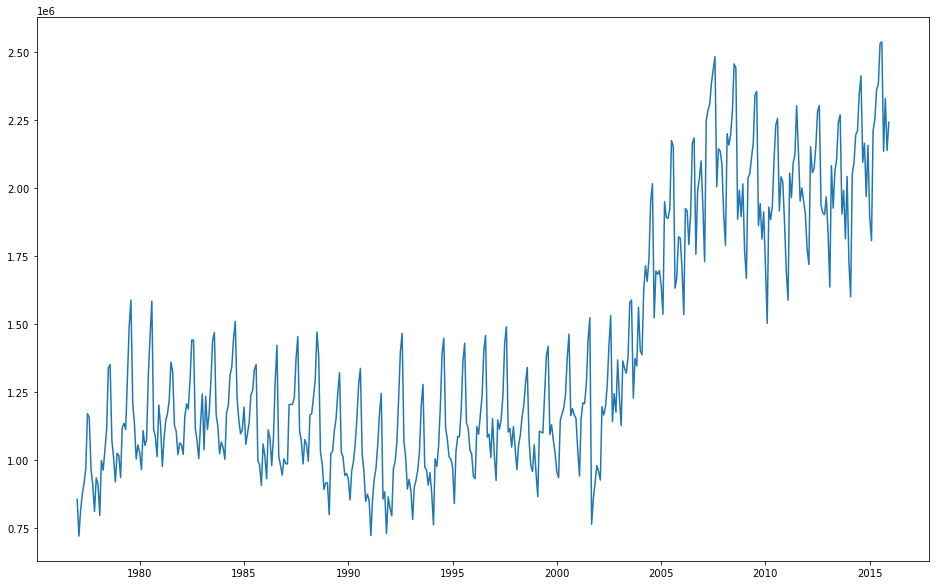

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

# Define the file location (acquired by cloning the repo at https://github.com/alan-turing-institute/TCPD.git)
ts_file = '/opt/notebooks/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

# Read the .csv file for the airport data set for New York and New Jersey
raw_data = pd.read_csv(ts_file)

# Make a shallow copy of the Pandas DataFrame so that we can mutate it safely.
raw_data = raw_data.copy(deep=False) 

# Add the month column by parsing the string-encoded month name, mutating the DataFrame by overwriting the column
raw_data['Month'] = pd.to_datetime(raw_data['Month'], format='%b').dt.month 

# Construct the day portion of the date as a field. For simplicity, we'll just use the 1st of the month.
raw_data.loc[:, 'Day'] = 1 

# Define a column by constructing the date components from the columns within the DataFrame.
raw_data['date'] = pd.to_datetime(raw_data[['Year', 'Month', 'Day']])

# Filter out only JFK data
jfk_data = raw_data[raw_data['Airport Code'] == 'JFK'] 

# Sort the data by the date so that our index, when applied as a datetime index, is ordered correctly.
# Failing to sort this properly can cause frustrating visual artifacts when plotting and issues with modeling later on. 
jfk_asc = jfk_data.sort_values('date', ascending=True) 

# Apply the date values as the index to the DataFrame (this simplifies a lot of work later on with both plotting and
# references to series objects when converted from Pandas to Numpy.)
jfk_asc.set_index('date', inplace=True) 

# Plot the data in the most basic (default) way
plt.plot(jfk_asc['Domestic Passengers'])
plt.show()


cool... I guess? What about the axis labels? What IS this data?
> This isn't a very good plot. Not to worry. We'll be making this much better.

### Listing 5.3 A blog example for ElasticNet from sklearn
>Note - this is intentionally made to be hyperbolic (but many blogs show nonsense just like this). Be very wary of where you get your examples from. Not everyone actually knows what they're talking about with many of the things that they're putting on the internet... ```</snide>```

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.linear_model import ElasticNet
from sklearn import metrics

# The old standby...
boston_data = datasets.load_boston() 
boston_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)
boston_df['House_Price'] = boston_data.target
# Seems like not too much feature engineering here, but ok. The data set is already pretty clean.
x = boston_df.drop('House_Price', axis=1)
y = boston_df['House_Price']

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state=42)

# huh? Where are all of the hyperparameters? We're not actually going to use the defaults, are we?
lm_elastic = ElasticNet()
lm_elastic.fit(train_x, train_y)
predict_lm_elastic = lm_elastic.predict(test_x)

# Great for blogs and books. Horrible in practice. Never print to stdout except when doing testing.
print('My score is:')
# Is this a good metric? Why are we only looking at MSE? Surely we could be looking at more than just this!
np.round(metrics.mean_squared_error(test_y, predict_lm_elastic))


My score is:


25.0

### Listing 5.4 The full API signature for ElasticNet on sklearn
This is meant to demonstrate all of the available (and testable) hyperparameters that should be tuned and refined for the use case. Each and every model that you attempt to build should be exploring these parameters. <br>
While some may argue that certain hyperparameters are pointless to test for certain applications (I would agree with them, as a matter of fact, but this knowledge requires a deep understanding of not only the algorithm, but the feature vector and the target as well), when getting started with a new model and application of said model, it doesn't hurt to test all available hyperparameters (at least, that is, until you look through the literature of how the model is built and why certain hyperparameters are only applicable in some circumstances for a particular use case).

In [4]:
elasticnet_regressor = ElasticNet(
  alpha=0.8,
  l1_ratio=0.6,
  fit_intercept=False,
  normalize=False,
  precompute=True,
  max_iter=5000,
  copy_X=True,
  tol=1e-6,
  warm_start=False,
  positive=True,
  random_state=42,
  selection='random'
)


### Listing 5.5 Moving average trend with 2-sigma error
In this example, we're going to be building an exploratory visualization of our data to augment the very basic (and questionably useful visualization from Listing 5.2). With applying a moving average for smoothing, we can help our brains 'reason' about the nature of the time series trend instead of just seeing a bunch of noise associated with the data.<br>
With the addition of a 2-sigma barrier around this moving average plot we can visualize the variance of the trend as centered around this moving average. Looking at changes in variance throughout a series can help to inform, once we do the research, which algorithms to test for performing an effective forecast of this data. Some algorithms are ill-suited for variability in variance, after all, and if there is instability in the variance over time, we can 'cull' our options to ensure that we're testing algorithms that will have a higher probability of success than approaches that cannot handle this deviation from 'normalcy' over time.

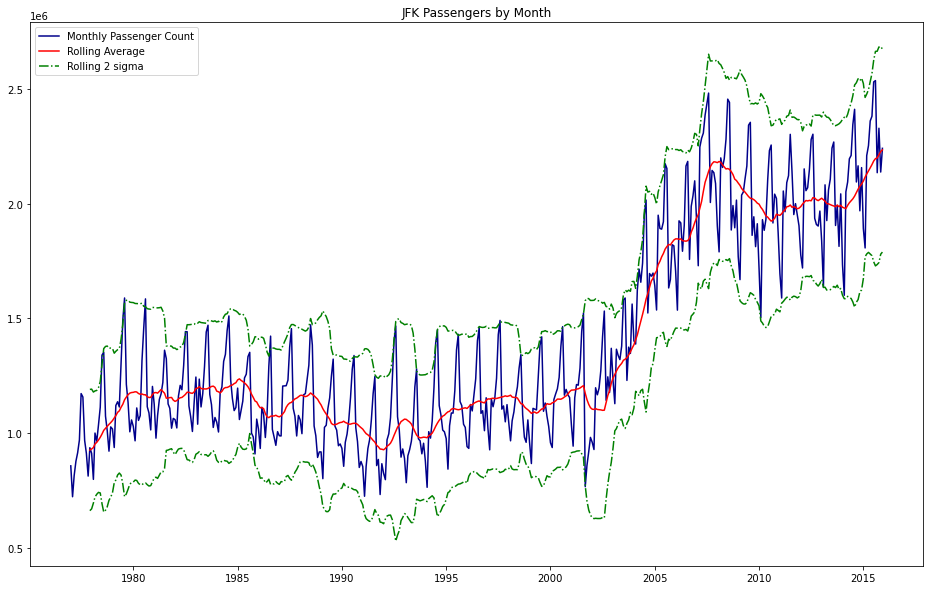

In [5]:
rolling_average = jfk_asc['Domestic Passengers'].rolling(12, center=False).mean()
rolling_std = jfk_asc['Domestic Passengers'].rolling(12, center=False).std()
plt.plot(jfk_asc['Domestic Passengers'], color='darkblue', label='Monthly Passenger Count')
plt.plot(rolling_average, color='red', label='Rolling Average')
plt.plot(rolling_average + (2 * rolling_std), color='green', linestyle='-.', label='Rolling 2 sigma')
plt.plot(rolling_average - (2 * rolling_std), color='green', linestyle='-.')
plt.legend(loc='best')
plt.title('JFK Passengers by Month')
plt.show(block=False)


### Listing 5.6 Stationarity test for a time series
One of the most useful tests for timeseries problems during the phase of 'what the heck models are we going to test?' part of a project.<br>
The stationarity test will help to inform 2 primary things:<br>
1. What models can we use without having to mutate the data (create a stationary time series through a log transformation) 
2. If we want to use models that require stationarity, at least we'll know if we have to enforce stationarity to get a passable result.
Having this sort of information before selecting models to test (and <b> certainly</b> well before we actually start trying to fit models to our data) will save us a lot of frustration and wasted time.<br>
>NOTE: This isn't applicable to just timeseries models. The concept of performing a statistical investigatory analysis on <b><i> any and all features being put into a model</i></b> is an absolutely critical step; whether we're doing timeseries modeling, classification, regression, or even reinforcement learning. We should always be seeking to <u><i>understand our data</i></u> before trying out model APIs.

In [6]:
from statsmodels.tsa.stattools import adfuller
# The Augmented Dickey-Fuller test for stationarity test. It will tell us 
# if the series is 'stable around the mean of the series'
# We're using Akaike information criterion here for fun. 
# I personally typically use BIC (Bayesian Information Criterion) most of the time since it typically gives
# a better representation of equivalence of estimation across different data sets within the same overall 'project'.
# BIC typically penalizes more for overly complex models, which I am not a fan of, due to the fact 
# that a more complex model is generally a more over-fit one, and thus, I use it more than AIC.
dickey_fuller_test = adfuller(jfk_asc['Domestic Passengers'], autolag='AIC')

# extract the first elements of the test
test_items = dickey_fuller_test[:4]

# Generate the report in human-readable text with an alpha value of 0.05 as the decision factor for the label.
report_items = test_items + (("not " if test_items[1] > 0.05 else "") + "stationary",)

# Create a nice little Pandas DataFrame of the report so that we can visualize it (and perhaps, later, record it)
df_report = pd.Series(report_items, 
                      index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationarity Test'])

# Dictionary comprehension to extract the values.
for k, v in dickey_fuller_test[4].items(): 
    df_report['Critical Value(%s)' % k] = v
    
# We're testing things right now, so it's ok to print. Don't ever do this in MVP or Production code.
print(df_report)


Test Statistic             -0.0498716
p-value                      0.954208
# Lags                             13
# Observations                    454
Stationarity Test      not stationary
Critical Value(1%)           -3.44484
Critical Value(5%)           -2.86793
Critical Value(10%)          -2.57017
dtype: object


### Listing 5.7 Trend decomposition for seasonality
Turns out that there is a really great trend decomposition tool that exists straight-out-of-the-box in Python (that is actually borrowed from an R implementation). Let's just use that to see what the components of our time series are.
> NOTE: Keep in mind that although we're using a time series problem here for demonstration purposes, all ML problems have complementary analyses that can (and most certainly SHOULD) be conducted for other types of problems. Doing a classification problem? Have you checked out your covariance results for your features? Have you checked them against your target variable? Have you done an ANOVA estimation of the magnitude of separation between label groups? Have you checked the Pearson Correaltion Coefficient values for a Regression problem? These are all incredibly critical to do before ever touching a modeling API.

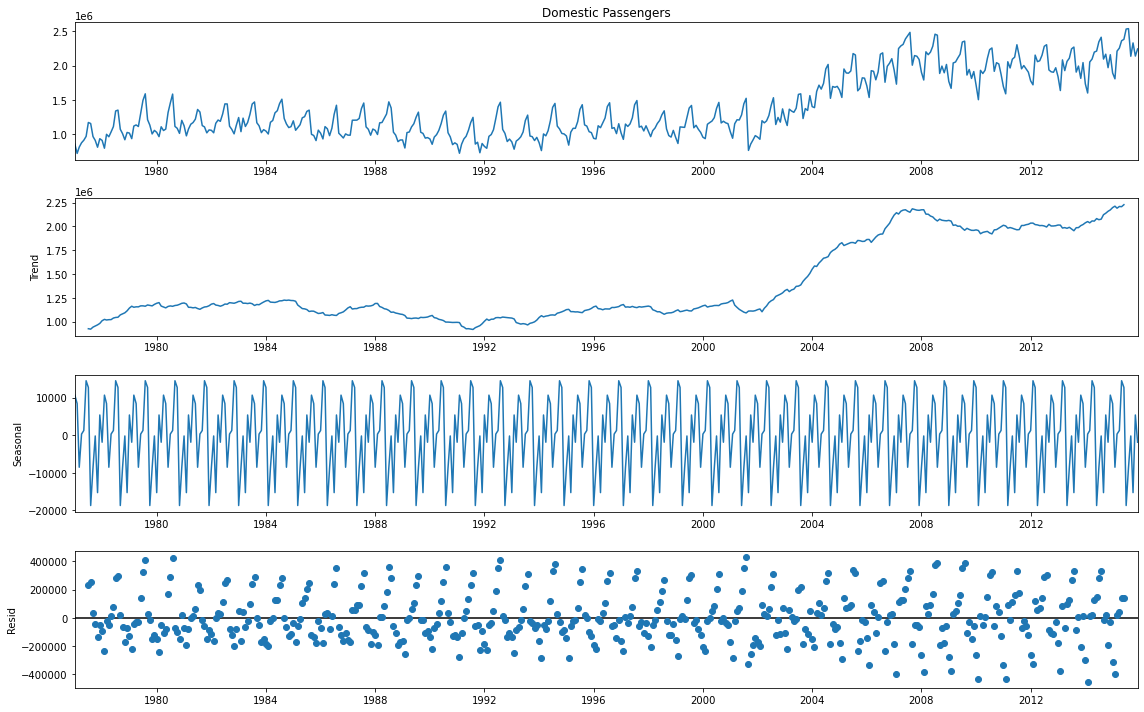

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the trend. We're going to use the results from the Augmented Dickey-Fuller test from listing 
# 5.6 above (13 lags) as the starting point.
decomposed_trends = seasonal_decompose(jfk_asc['Domestic Passengers'], period=13)

# The API has a nice little wrapper around matplotlib to create a cool figure with subplots in it...
trend_plot = decomposed_trends.plot()

# Save the results to our local mirrored drive location (that we set up when we configured the Docker image)
# so that if we need to show this graphic in a meeting or to just share the results with other team members,
# we don't have to open a notebook or take a screencapture of a notebook.
# The bonus with svg format is that it can scale the graphics to any resolution. I highly recommend it.
plt.savefig("decomposed13.svg", format='svg')

That's not that great. There seems to be a predictable pattern in the residuals, right? We really need to adjust that...

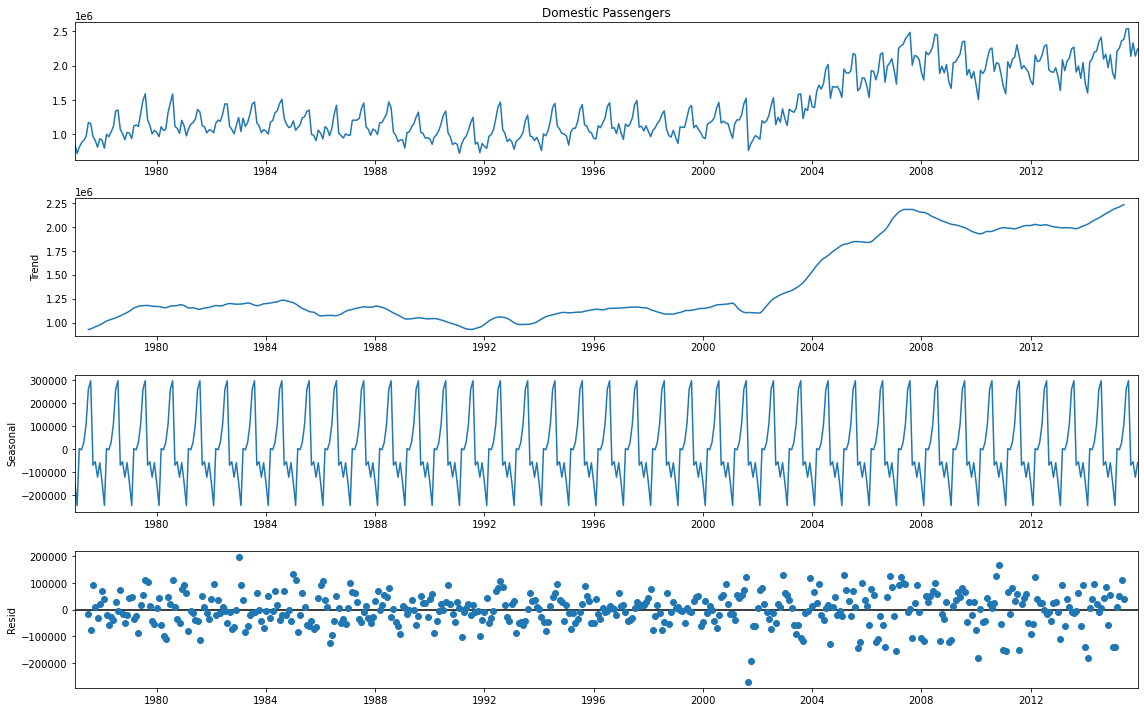

In [8]:
# Things happen yearly, right? There's 12 months in a year the last time I checked...
decomposed_trends_adj = seasonal_decompose(jfk_asc['Domestic Passengers'], period=12)
trend_plot = decomposed_trends_adj.plot()
plt.savefig("decomposed12.svg", format='svg')

Wow, that is <i><b>SO MUCH BETTER</b></i>. The residuals show no real pattern to the eye, the seasonality trend looks nice and repeatable, and we have a clear trend line that shows the 'essence' of the general shape of the data over time. NICE.

### Listing 5.8 Time series differencing functions and visualizations
Now we're moving into the realm of customized plots. Since we know we're going to be looking at these trends quite a bit during our exploratory and research phases, we should have something that looks a bit easier on the eyes and provides all of the information that we need for a particular time series in a single easy-to-use visualization. The visualizations (and the operations that they're performing on the data series) are enforcing stationarity. (the 2nd and 3rd plots).<br>
As mentioned earlier, there are certain models that <b>require stationarity</b> to make an effective prediction. We'll be doing something slightly more fancy later, but for now, a differencing function can remove the trend component (that's stationarity - the fact that the mean and the variance of the data set do not effectively change over time - the augmented Dickey-Fuller test is checking for a unit root to determine this stationarity).
<br>We'll work on making this reusable with a function later on.

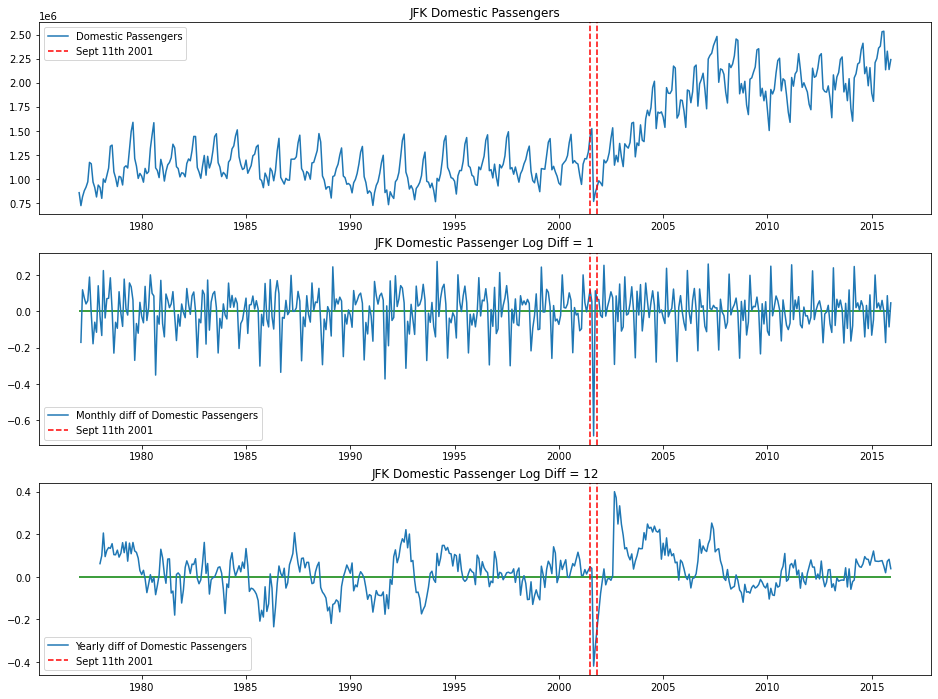

In [9]:
from datetime import datetime
jfk_asc['Log Domestic Passengers'] = np.log(jfk_asc['Domestic Passengers'])
jfk_asc['DiffLog Domestic Passengers month'] = jfk_asc['Log Domestic Passengers'].diff(1)
jfk_asc['DiffLog Domestic Passengers year'] = jfk_asc['Log Domestic Passengers'].diff(12)
fig, axes = plt.subplots(3, 1, figsize=(16,12))
boundary1 = datetime.strptime('2001-07-01', '%Y-%m-%d')
boundary2 = datetime.strptime('2001-11-01', '%Y-%m-%d')
axes[0].plot(jfk_asc['Domestic Passengers'], '-', label='Domestic Passengers')
axes[0].set(title='JFK Domestic Passengers')
axes[0].axvline(boundary1, 0, 2.5e6, color='r', linestyle='--', label='Sept 11th 2001')
axes[0].axvline(boundary2, 0, 2.5e6, color='r', linestyle='--')
axes[0].legend(loc='upper left')
axes[1].plot(jfk_asc['DiffLog Domestic Passengers month'], label='Monthly diff of Domestic Passengers')
axes[1].hlines(0, jfk_asc.index[0], jfk_asc.index[-1], 'g')
axes[1].set(title='JFK Domestic Passenger Log Diff = 1')
axes[1].axvline(boundary1, 0, 2.5e6, color='r', linestyle='--', label='Sept 11th 2001')
axes[1].axvline(boundary2, 0, 2.5e6, color='r', linestyle='--')

axes[1].legend(loc='lower left')
axes[2].plot(jfk_asc['DiffLog Domestic Passengers year'], label='Yearly diff of Domestic Passengers')
axes[2].hlines(0, jfk_asc.index[0], jfk_asc.index[-1], 'g')
axes[2].set(title='JFK Domestic Passenger Log Diff = 12')
axes[2].axvline(boundary1, 0, 2.5e6, color='r', linestyle='--', label='Sept 11th 2001')
axes[2].axvline(boundary2, 0, 2.5e6, color='r', linestyle='--')
axes[2].legend(loc='lower left')
plt.savefig("logdiff.svg", format='svg')


Now that we're taking a look at a stationarity conversion of the data set, what happens if we run our Dickey-Fuller test against the 2nd plot? Let's try that real quick just to make sure that the time series is actually stationary.
> NOTE: This copy-paste-rename nonsense that we're doing here is to illustrate a point. We <b> should not be</b> copying this code and renaming things. We should, instead, be creating a function. We'll get to that a little later, though.

In [10]:
# Let's take that diff function and then drop the na's that result from the first row having nothing to 
# subtract from.
dickey_fuller_test_modded = adfuller(jfk_asc['Domestic Passengers'].diff(1).dropna(), autolag='AIC')

# take out the top-level from the dictionary that is returned by this function adfuller()
test_items_modded = dickey_fuller_test_modded[:4]

# make a human readable assertion on the stationarity of the data series with a 95% confidence estimation
report_items_modded = test_items_modded + (("not " if test_items_modded[1] > 0.05 else "") + "stationary",)

# created a DataFrame out of this data in case we want to store it somewhere later on
df_report_modded = pd.Series(report_items_modded, 
                      index=['Test Statistic', 'p-value', '# Lags', '# Observations', 'Stationarity Test'])

# extract the nested elements from the non-top-level elements returned from the adfuller() function
for k, v in dickey_fuller_test_modded[4].items(): 
    df_report_modded['Critical Value(%s)' % k] = v

# for illustrative purposes only. Don't print in your code unless you're quickly verifying something.
print(df_report_modded)

Test Statistic            -5.69697
p-value                7.83355e-07
# Lags                          12
# Observations                 454
Stationarity Test       stationary
Critical Value(1%)        -3.44484
Critical Value(5%)        -2.86793
Critical Value(10%)       -2.57017
dtype: object


Sweet! We have stationarity! Look at that p-value! The test statistic is so far below all of the critical values that we can state with <u><i>very high confidence</i></u> that this time series has a uniform mean and a uniform variance. There are some models, as has been said earlier, that really need this sort of 'stability' to forecast properly. 
> NOTE: we could see from the plots above that this was the case (that we effectively achieved stationarity). However, it's important to have the statistical tests to enforce our visual cues. Many data sets are not quite this easy to visualize. Conversely, we should also be looking at a visual representation of our data at all times and not solely rely on the statistical scores. Both approaches are <b><u><i>complementary and should be used together</i></u></b> when doing our analyses as Data Scientists.

### Listing 5.9 Data Ingestion and formatting functions
Now we come to the part where we stop copying code. We should be defining functions to encapsulate repeatedly used operations for three main reasons:
1. Copying and pasting code is extremely error-prone. If we forget to update a variable definition, we could be using a reference to something that was defined earlier if we're working in a notebook.
2. It's time consuming, and frankly, extremely annoying to manually walk through script and update values. There are <b>so many better things to do with your time</b> than spending it updating text from something that you copied and pasted.
3. It makes your scripts look monolithic, painful to read, and impossible to troubleshoot if something goes wrong. 
We'll be going through how to create functions to make our lives easier in this section and will eventually get to encapsulating commonly used functionality into packages in later chapters.

In [11]:
# Static (read: unchanging) variables in Python (and many other languages) are defined as underscore-seperated
# capitalized names. This isn't to help the computer understand what you're doing. It's a STANDARD to help 
# other HUMANS to quickly understand what that particular variable means in the scope of your code. 
AIRPORT_FIELD = 'Airport Code'

# A function for applying the time series frequency to the index. This can help with filling in missing data
# for 'real world' data sets and ensures that your visualizations, statistics, and models are seeing a 
# continuous, un-interrupted series of data. This is VERY IMPORTANT.
def apply_index_freq(data, freq): 
    return data.asfreq(freq)

# A simple function for pulling in the data through the Pandas read csv API, applying the data formatting to 
# construct the index, and generating the index with the correct periodicity. 
# (note: this is the code from listing 5.2, wrapped in a function)
def pull_raw_airport_data(file_location):
    raw = pd.read_csv(file_location)
    raw = raw.copy(deep=False)
    raw['Month'] = pd.to_datetime(raw['Month'], format='%b').dt.month
    raw.loc[:, 'Day'] = 1
    raw['date'] = pd.to_datetime(raw[['Year', 'Month', 'Day']])
    raw.set_index('date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

# A function to return just one airport's data in the correct indexed manner (preparing us for the next phase
# of our research and experimentation phase where we're going to be testing forecasting models on one
# airport at a time).
def get_airport_data(airport, file_location): 
    all_data = pull_raw_airport_data(file_location)
    filtered = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered

# A utility function that supports taking the full airport data that has been read in and returning a subset
# (a single airport's worth of data from the in-memory 'master file' Pandas DataFrame).
def filter_airport_data(all_data, airport):
    filtered_data = all_data[all_data[AIRPORT_FIELD] == airport]
    return filtered_data

# A utility function that, when used as a 'command and control' utility for filter_airport_data() can allow us
# to build models for all of the airports in a loop. We will be exploring this use in depth in Chapter 7.
def get_all_airports(file_location): 
    all_data = pull_raw_airport_data(file_location)
    unique_airports = all_data[AIRPORT_FIELD].unique()
    return sorted(unique_airports)


### Listing 5.10 Ingesting data by using a reusable function
And here's the proof of why we're defining this <b><u> once as a function </u></b> instead of copying and pasting the script in Listing 5.2 every time we need to load in the raw data.

In [12]:
# This STATIC VARIABLE definition needs only to be defined ONCE in our code (typically at the top of a notebook
# if we're using notebooks, in a configuration Object if we're doing OO-designed code paradigms 
# (i.e. production ML code))
DATA_PATH = '/opt/notebooks/TCPD/datasets/jfk_passengers/air-passenger-traffic-per-month-port-authority-of-ny-nj-beginning-1977.csv'

# A one-liner to get our data for JFK airport.
jfk = get_airport_data('JFK', DATA_PATH) 

# Another one-liner to apply the correct timeseries frequency to the index.
jfk = apply_index_freq(jfk, 'MS') 


In [13]:
# let's see what the results are...
jfk

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
1977-01-01,JFK,1977,1,856626,630962,1487588,1
1977-02-01,JFK,1977,2,722025,515694,1237719,1
1977-03-01,JFK,1977,3,813601,636794,1450395,1
1977-04-01,JFK,1977,4,876631,732528,1609159,1
1977-05-01,JFK,1977,5,913548,810844,1724392,1
...,...,...,...,...,...,...,...
2015-08-01,JFK,2015,8,2535971,3273753,5809724,1
2015-09-01,JFK,2015,9,2134468,2647629,4782097,1
2015-10-01,JFK,2015,10,2328298,2571768,4900066,1
2015-11-01,JFK,2015,11,2137376,2204682,4342058,1


In [14]:
# And now, let's take a look at another airport's data.
lga = apply_index_freq(get_airport_data('LGA', DATA_PATH) ,'MS')
lga

,Airport Code,Year,Month,Domestic Passengers,International Passengers,Total Passengers,Day
1977-01-01,LGA,1977,1,1093062,0,1093062,1
1977-02-01,LGA,1977,2,1020854,0,1020854,1
1977-03-01,LGA,1977,3,1214632,0,1214632,1
1977-04-01,LGA,1977,4,1257855,0,1257855,1
1977-05-01,LGA,1977,5,1263020,0,1263020,1
...,...,...,...,...,...,...,...
2015-08-01,LGA,2015,8,2493267,182041,2675308,1
2015-09-01,LGA,2015,9,2192655,147775,2340430,1
2015-10-01,LGA,2015,10,2382229,147655,2529884,1
2015-11-01,LGA,2015,11,2210872,122683,2333555,1


Ok, so that last one <i><b>may</b></i> have been a little confusing. What we did there was <u><i>curry</i></u> the result from get_airport_data() into the function apply_index_freq().<br>
We can do that because the <u>return type</u> of the inner function is the same as the <u>input type</u> of the second (encapsulating) function.

### Listing 5.11 Reusable function for visualizing outlier data
This one is a bit of a sore spot for me. Back when I was a very junior Data Scientist (back before we called ourselves that) I used to struggle quite a bit with visualizations. Scripting them each by hand, fine-tuning column reference names, setting parameters manually... <br>
If there were one thing I wished I had learned in my early years of doing this profession, it would have been learning how to produce reusable functions for visualizations. Not only is the documentation for some of the popular visualization libraries rather confusing and incomplete, but the script itself is... shall we say... 'verbose'. <br>
Let's take a look at one of these rather annoying visualizations and breathe a collective sigh of relief that we will only have to assemble these plots once, thereafter generating them through a simple function call with the data-specific arguments needed.<br>
For this example, we're going to be wrapping the code from Listing 5.8 into a function that allows us to specify a particular event date that something happened that we really couldn't have predicted and how it affected the time series data. <br>
Plots such as these may not be super helpful to the DS team specifically, but they are great tools for communicating in clear and obvious language (the language of visually-impactful representations of data) for laypersons at your company to 'grok' almost instantly. I highly recommend spending a little bit of time in each project to think about and build a visualization such as this to help to explain why abberations exist in your data sets. It's always better to have something like this in your back pocket to illustrate to a business-unit team than to scramble to create something later on when they're demanding answers about why certain predictions are happening.
> <b>Note:</b> Developers love to argue about 'maximum arguments' being passed into a function. In the function argument signature below, we have 6 arguments. <br>
>For some, who come from a background writing embedded systems code in C or C++, there are (or were) hardware restrictions that have historically been hard requirements (i.e. the Intel 8084 chip set could support only 4 arguments to any function or method call due to the limitations of its registry). Be that as it may, we're not writing embedded systems code while doing ML. We're on 64-bit Linux (most of the time) systems running CPUs whose registers are at a minimum 8-bit (allowing for 255 arguments to a function), and most signficantly more than that. <br>
> What the choice of argument length comes down to is human readability. Do you want a massive wall of arguments defined in the function or method definition? Probably not. There are other means (some harder to use than others), particularly in Python, that allow for nigh indefinite (there is still a limit - don't try to pass millions of parameters in a dictionary) amounts of arguments. The computer, after all, can likely handle it. Our eyes, however, can't. <br>
>If you find yourself going down the path of having dozens of arguments into a single function, you might want to think about refactoring the code so that you don't have a monolithic function that requires so many input arguments. The other option to refactoring (although you should definitely refactor often and thoroughly to make the code more readable and maintainable) is to use variable length arguments. `*args` `**kwargs` are both very effective means of keeping code looking clean. There is a trade-off with using the positional notation and dictionary-based argument passing - namely that the USER of the function or method needs some sort of documentation that lists out all of the arguments and refer to that when using the function or method (as opposed to the declared arguments which are readily viewable). 

In [15]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

# See note above regarding argument count lengths. Stick with what you're comfortable with
# and what the team at-large agrees on as a standard. Pay no attention to the flame wars about this topic.
# also, this is an example of a doc string in Python. There will be more of these (particularly when we get
# to class-based methods, but for the remainder of this chapter, I'm not going to be putting these in)

def generate_outlier_plots(data_series, series_name, series_column, event_date, event_name, image_name):
    """
    Function for generating outlier plot data.
    :param data_series: The timeseries series element (indexed by date) to plot
    :param series_name: A human-readable name for the time series for applying a label to the plot
    :param series_column: The name of the series column within the passed in DataFrame
    :event_date: A date specified that marks an outlier event to flag in the plot
    :event_name: An explanatory string that represents what the outlier event is to provide context in the plot
    :image_name: The name of the file to create in svg format to save the plot to local file system
    :return: the pyplot figure.
    """
    # create column names for the differencing stationary functions
    log_name = 'Log {}'.format(series_column)
    month_log_name = 'DiffLog {} month'.format(series_column)
    year_log_name = 'DiffLog {} year'.format(series_column)
    
    # Convert the passed in event date to a timetime object
    event_marker = datetime.strptime(event_date, '%Y-%m-%d').replace(day=1)
    
    # create boundary lines around the event for visual purposes
    two_month_delta = relativedelta(months=2)
    event_boundary_low = event_marker - two_month_delta
    event_boundary_high = event_marker + two_month_delta
    
    # get the max value for the y axis so that we can draw the vertical component correctly
    max_scaling = np.round(data_series[series_column].values.max() * 1.1, 0)
    
    # create a deep copy (direct in-memory copy of the original series) so that we can mutate it safely
    data = data_series.copy(deep=True)
    
    # add in the differencing columns
    data[log_name] = np.log(data[series_column])
    data[month_log_name] = data[log_name].diff(1)
    data[year_log_name] = data[log_name].diff(12)
    
    # Generate the plot layout -> 3 rows, 1 column, 16 inches by 12 inches.
    fig, axes = plt.subplots(3, 1, figsize=(16, 12))
    
    # axes[0] is the top plot. Populate the data to the axes element for the top plot.
    axes[0].plot(data[series_column], '-', label=series_column)
    axes[0].set(title='{} {}'.format(series_name, series_column))
    
    # draw the vertical boundary lines (offset 2 months on either side of the passed in date)
    axes[0].axvline(event_boundary_low, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[0].axvline(event_boundary_high, 0, max_scaling, color='r', linestyle='--')
    axes[0].legend(loc='best')
    
    # plot the 1-month differenced series data and overlay the same vertical lines as axes[0] plot.
    axes[1].plot(data[month_log_name], label='Monthly diff of {}'.format(series_column))
    axes[1].hlines(0, data.index[0], data.index[-1], 'g')
    axes[1].set(title='{} Monthly diff of {}'.format(series_name, series_column))
    axes[1].axvline(event_boundary_low, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[1].axvline(event_boundary_high, 0, max_scaling, color='r', linestyle='--')
    axes[1].legend(loc='best')
    
    # plot the 12-month differenced series data.
    axes[2].plot(data[year_log_name], label='Year diff of {}'.format(series_column))
    axes[2].hlines(0, data.index[0], data.index[-1], 'g')
    axes[2].set(title='{} Yearly diff of {}'.format(series_name, series_column))
    axes[2].axvline(event_boundary_low, 0, max_scaling, color='r', linestyle='--', label=event_name)
    axes[2].axvline(event_boundary_high, 0, max_scaling, color='r', linestyle='--')
    axes[2].legend(loc='best')
    
    # save the image
    plt.savefig(image_name, format='svg')
    # return the image from the function so that we can embed it in a more complex return type later
    # when we want to wrap all of these calls in a more complex execution chain.
    return fig


### Listing 5.12 Usage of the outlier visualization function
Now that we have this function developed, let's plot two different airports data and see how easy it is to do so without resorting to scripting and instead using functions. (This is slightly different than the example in the book; intentionally so. Feel free to play around with different aspects of this data set and different dates to see how they all can modify the plots with simple argument changes).

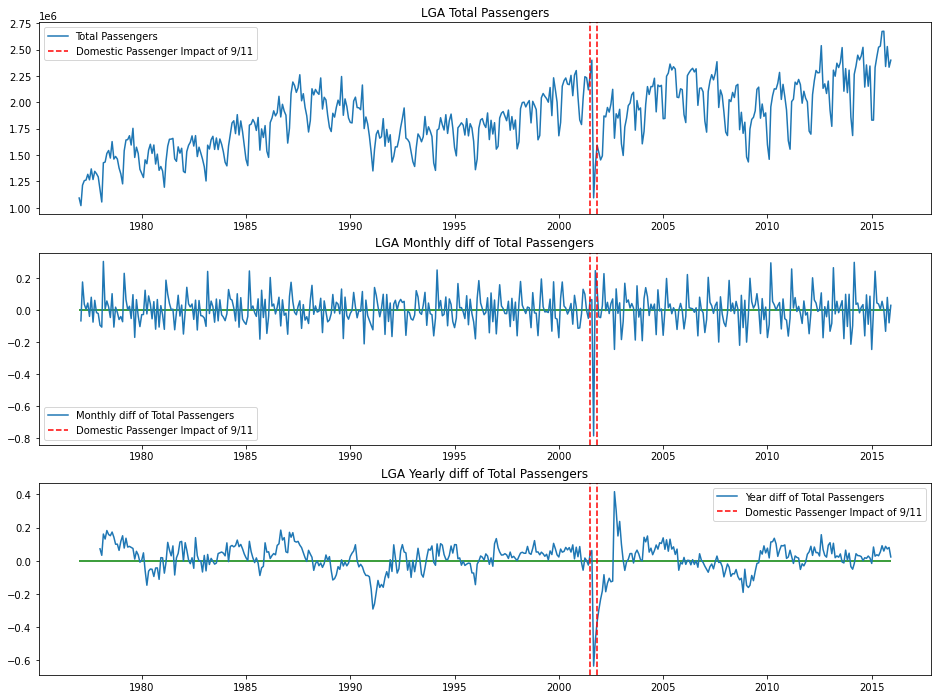

In [16]:
lga_data = apply_index_freq(get_airport_data('LGA', DATA_PATH), 'MS')
lga_outlier = generate_outlier_plots(lga_data, 'LGA', 'Total Passengers', '2001-09-11', 
                                     'Domestic Passenger Impact of 9/11', 'LaGuardiaImpactSep11.svg')

### Listing 5.13 Experimental phase function use for outlier analysis
In the listing section for the book, we look at the impact of 9/11 on Domestic Passengers at LaGuardia. Here's let's show the impact at Newark International Airport.

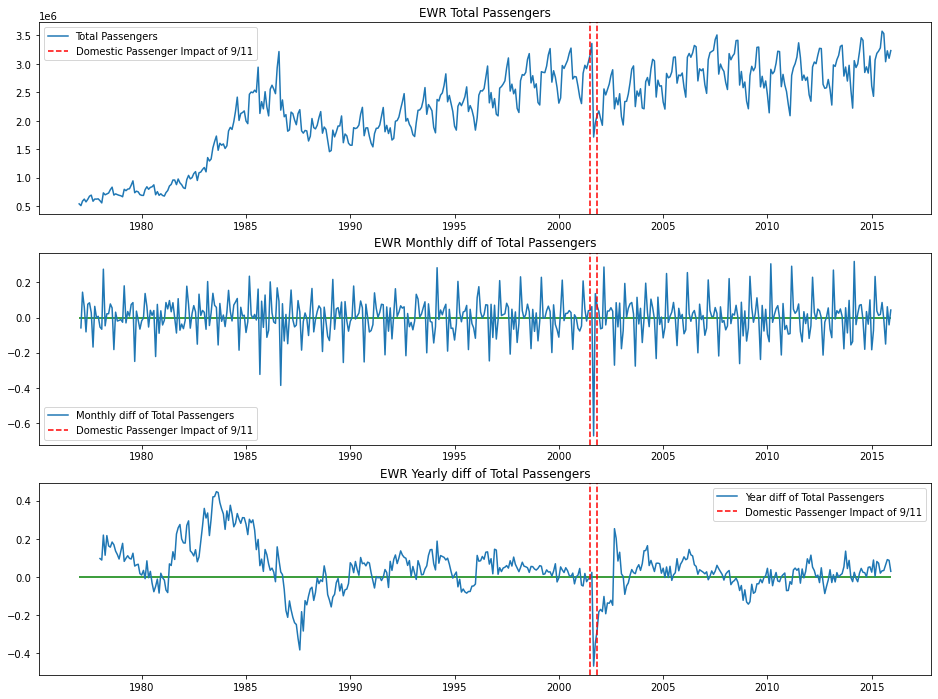

In [17]:
ewr_data = apply_index_freq(get_airport_data('EWR', DATA_PATH), 'MS')
ewr_outlier = generate_outlier_plots(ewr_data, 'EWR', 'Total Passengers', '2001-09-11', 
                                     'Domestic Passenger Impact of 9/11', 'NewarkImpactSep11.svg')

I certainly wouldn't want to update a script to produce these plots... Using a function is so much easier.

### Listing 5.14 Standardized time series visualization and analysis for model preparation
In this section, we're going to be building a visualization that will be a reference for anyone who is going to be working on the prototypes for different modeling approaches. Not only will we be getting the trend decompositions, but we'll be tacking on the autocorrelation and partial autocorrelation plots (that will help us determine where to start with tuning of certain models).
> This wall of text of a function is <b><i>definitely</i></b> something that we will only want to write once as a reusable function.

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def stationarity_tests(time_df, series_col, time_series_name, period, image_name, lags=12, cf_alpha=0.05, 
                       style='seaborn', plot_size=(16, 32)):
    log_col_name = 'Log {}'.format(series_col) 
    diff_log_col_name = 'LogDiff {}'.format(series_col) 
    time_df[log_col_name] = np.log(time_df[series_col])
    time_df[diff_log_col_name] = time_df[log_col_name].diff()
    decomposed_trend = seasonal_decompose(time_df[series_col], period=period)
    df_index_start = time_df.index.values[0]
    df_index_end = time_df.index.values[len(time_df)-1]
    with plt.style.context(style=style):
        fig, axes = plt.subplots(7, 1, figsize=plot_size)
        plt.subplots_adjust(hspace=0.3)
        axes[0].plot(time_df[series_col], '-', label='Raw data for {}'.format(time_series_name))
        axes[0].legend(loc='upper left')
        axes[0].set_title('Raw data trend for {}'.format(time_series_name)) 
        axes[0].set_ylabel(series_col)
        axes[0].set_xlabel(time_df.index.name)
        axes[1].plot(time_df[diff_log_col_name], 'g-', label='Log Diff for {}'.format(time_series_name))
        axes[1].hlines(0.0, df_index_start, df_index_end, 'r', label='Series center')
        axes[1].legend(loc='lower left')
        axes[1].set_title('Diff Log Trend for outliers in {}'.format(time_series_name))
        axes[1].set_ylabel(series_col)
        axes[1].set_xlabel(time_df.index.name) 
        # the auto-correlation factor and the partial auto-correlation factors can help set hyperparameters
        # for many of the models we'll be testing out in the next chapter.
        fig = plot_acf(time_df[series_col], lags=lags, ax=axes[2])
        fig = plot_pacf(time_df[series_col], lags=lags, ax=axes[3])
        axes[2].set_xlabel('lags')
        axes[2].set_ylabel('correlation')
        axes[3].set_xlabel('lags')
        axes[3].set_ylabel('correlation')
        axes[4].plot(decomposed_trend.trend, 'r-', label='Trend data for {}'.format(time_series_name))
        axes[4].legend(loc='upper left')
        axes[4].set_title('Trend component of decomposition for {}'.format(time_series_name))
        axes[4].set_ylabel(series_col)
        axes[4].set_xlabel(time_df.index.name)
        axes[5].plot(decomposed_trend.seasonal, 'r-', label='Seasonal data for {}'.format(time_series_name))
        axes[5].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[5].set_title('Seasonal component of decomposition for {}'.format(time_series_name))
        axes[5].set_ylabel(series_col)
        axes[5].set_xlabel(time_df.index.name)
        axes[6].plot(decomposed_trend.resid, 'r.', label='Residuals data for {}'.format(time_series_name))
        axes[6].hlines(0.0, df_index_start, df_index_end, 'black', label='Series Center')
        axes[6].legend(loc='center left', bbox_to_anchor=(0,1))
        axes[6].set_title('Residuals component of decomposition for {}'.format(time_series_name))
        axes[6].set_ylabel(series_col)
        axes[6].set_xlabel(time_df.index.name)
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return fig

### Listing 5.15 Trend visualization for Newark Domestic Passengers
This is the callee of the stationarity_tests function from listing 5.14. 

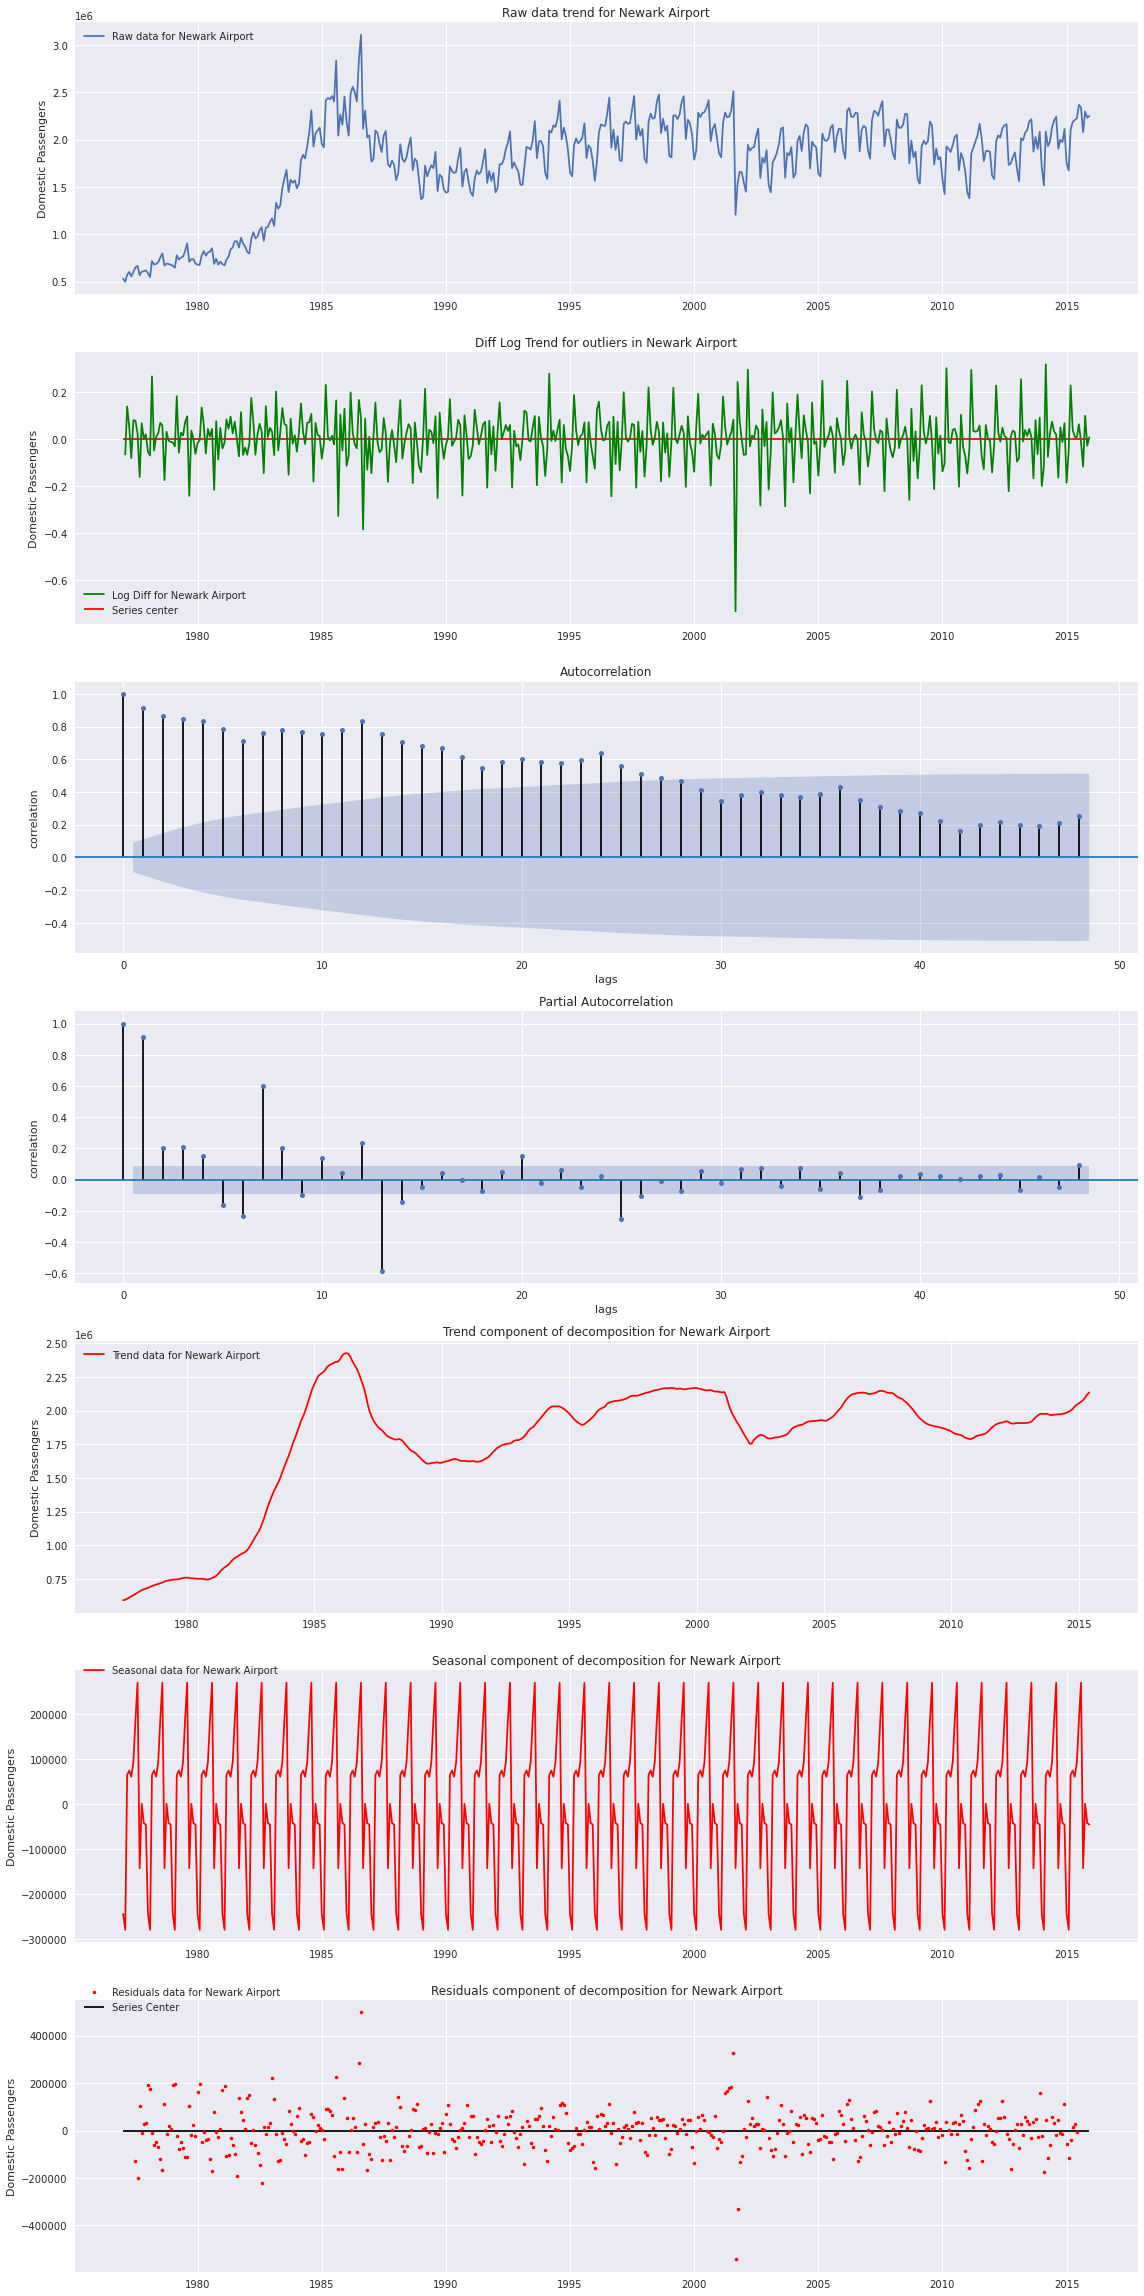

In [19]:
ewr_dom = apply_index_freq(get_airport_data('EWR', DATA_PATH), 'MS')
ewr_stationarity_plots = stationarity_tests(ewr_dom, 'Domestic Passengers', 
                                            'Newark Airport', 12, 'newark_domestic_plots.svg', 48, 0.05)
